# Задача: Виртуализация данных
## Описание:
Опираясь на пример визуализации в блокноте для данной ЛР, придумайте 3 графика по предоставленным данным по инцидентам, активам и уязвимостям. 
1. Может быть построен только на одном источнике
2. Должен быть построен как минимум на двух источниках (условно Инц. и Акт.)
3. Должен быть построен как минимум на двух источниках, но другой пары (Инц. и Уязв. или Акт. и Уязв.)

In [1]:
import ast

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

incidents_df = pd.read_csv('incidents_nonlinear.csv')
assets_df = pd.read_csv('assets_nonlinear.csv')
vulnerabilities_df = pd.read_csv('vulnerabilities_nonlinear.csv')

incidents_df.head()


,team,id,name,description,type,events_count,crit_rate,assets_id,vulnerabilities_id,start_time,end_time
0,911,374684,Инъекция кода,"Обнаружена активность ""Инъекция кода"" с уязвим...",Проникновение,3,8.77,[17896],"[39877, 42000, 18332, 21116]",2023-10-29 21:37:47.014175,2023-10-29 21:59:47.014175
1,911,521350,Добавление учетной записи,"Обнаружена активность ""Добавление учетной запи...",Закрепление,25,5.42,[17896],"[77720, 37759, 96937]",2023-10-29 21:59:47.027887,2023-10-29 22:50:47.027887
2,911,208144,WinRM,"Обнаружена активность ""WinRM"" с уязвимостями 8...",Боковое передвижение,9,7.33,"[17896, 51727]","[82308, 63348, 48844, 11329]",2023-10-29 22:50:47.041594,2023-10-29 23:15:47.041594
3,911,725372,Управление учетными данными,"Обнаружена активность ""Управление учетными дан...",Повышение прав,40,5.69,[51727],"[54681, 89359, 61430, 45576, 81153]",2023-10-29 23:15:47.055305,2023-10-30 00:05:47.055305
4,911,153774,Доступ к файлам,"Обнаружена активность ""Доступ к файлам"" с уязв...",Действия на целевом устройстве,1,9.32,[51727],"[11245, 68026, 29098, 38356]",2023-10-30 00:05:47.069015,2023-10-30 00:42:47.069015


# Задание 1.
Цель Виртуализации: Определить виды и время инцидентов с наибольшей критичностью

Задача Виртуализации: Получить среднее кол-во критичности инцидента, сгруппированных по типу и построить график их временной зависимости

Меняем типы данных внутри датафреймов

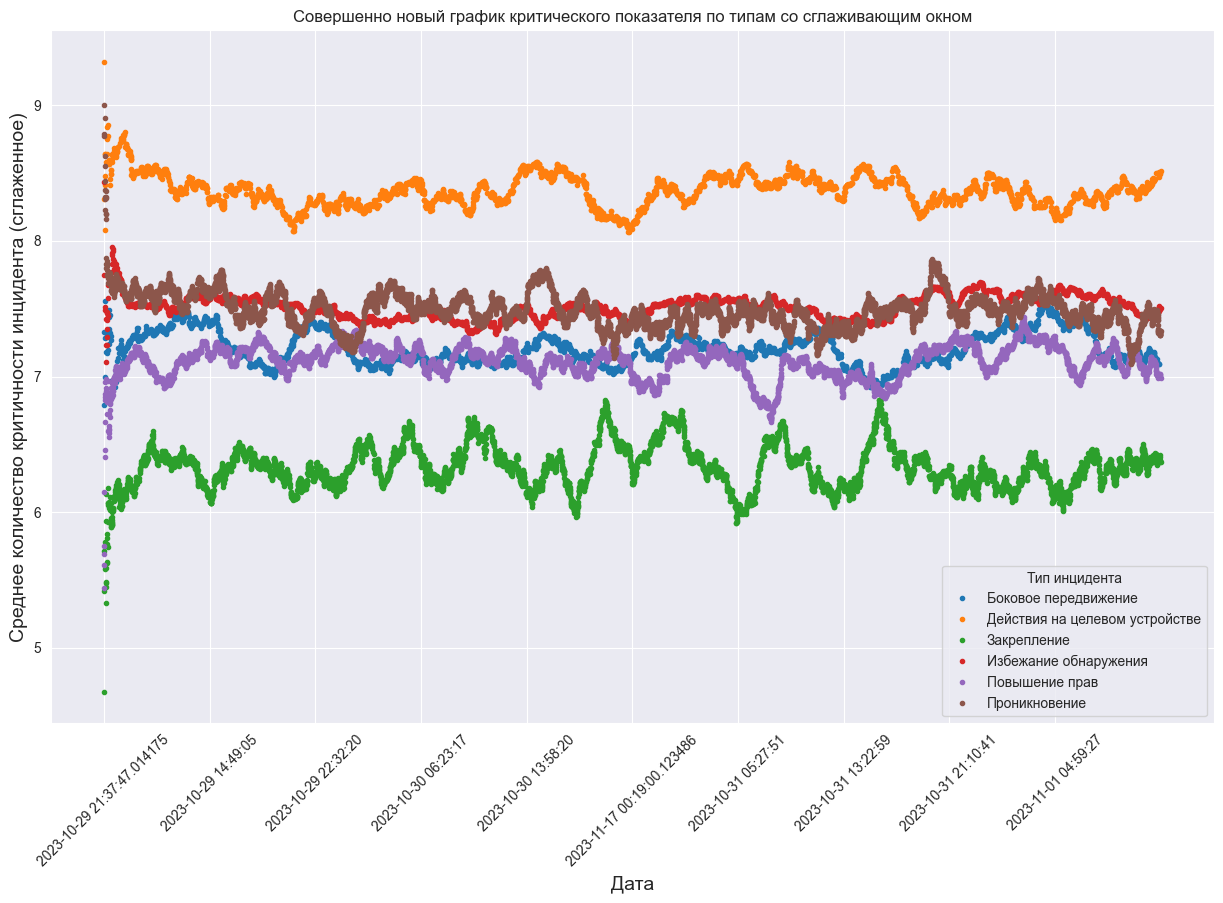

In [2]:
def listify(s):
    return [n for n in ast.literal_eval(s)] # меняем тип строки на список интов

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "Утро"
    elif 12 <= hour < 18:
        return "День"
    elif 0 <= hour < 6:
        return "Ночь"
    else:
        return "Вечер"



incidents_df['vulnerabilities_id'] = incidents_df['vulnerabilities_id'].apply(lambda x: listify(x))
incidents_df['assets_id'] = incidents_df['assets_id'].apply(lambda x: listify(x))
# incidents_df['vulnerabilities_id'][1]
incidents_df['start_time'] = pd.to_datetime(incidents_df['start_time'])
incidents_df['end_time'] = pd.to_datetime(incidents_df['end_time'])

# Группировка по типу и дате, с расчетом среднего количества событий с использованием скользящего окна
incidents_df['crit_rate_smooth'] = incidents_df\
.groupby('type')['crit_rate']\
.transform(lambda x: x.rolling(window=150, min_periods=1).mean())  # метод возвращает таблицу с теми же столбцами, но преобразованными функцией-аргументом


incs_gby_type = incidents_df.groupby('type')

f = plt.figure(figsize=(15, 9))
ax = f.add_subplot(111, label='1')


incs_for_plot1 = incs_gby_type['crit_rate_smooth']  # [['start_time', 'events_count_smooth']]

incs_for_plot1.plot(ls='', marker='.')

fontsize=14
ax.set_xticks(labels=incidents_df['start_time'][::incidents_df.shape[0]//10], ticks=list(range(0, incidents_df.shape[0], incidents_df.shape[0]//10)), rotation=45)
ax.set_title('Совершенно новый график критического показателя по типам со сглаживающим окном')
ax.set_ylabel('Среднее количество критичности инцидента (сглаженное)', fontsize=fontsize)
ax.set_xlabel('Дата', fontsize=fontsize)
ax.legend(title='Тип инцидента')
plt.grid(True)

# plt.tight_layout()
plt.show()

Выводы: Действия на целевом уст-ве имеют наб-ю критичность

# Задача 2

Цель виртуализации: Определить самые важные ОС при инцидентах

Задача виртуализации: Строим зависисомть критичности инцидента от ОС по времени

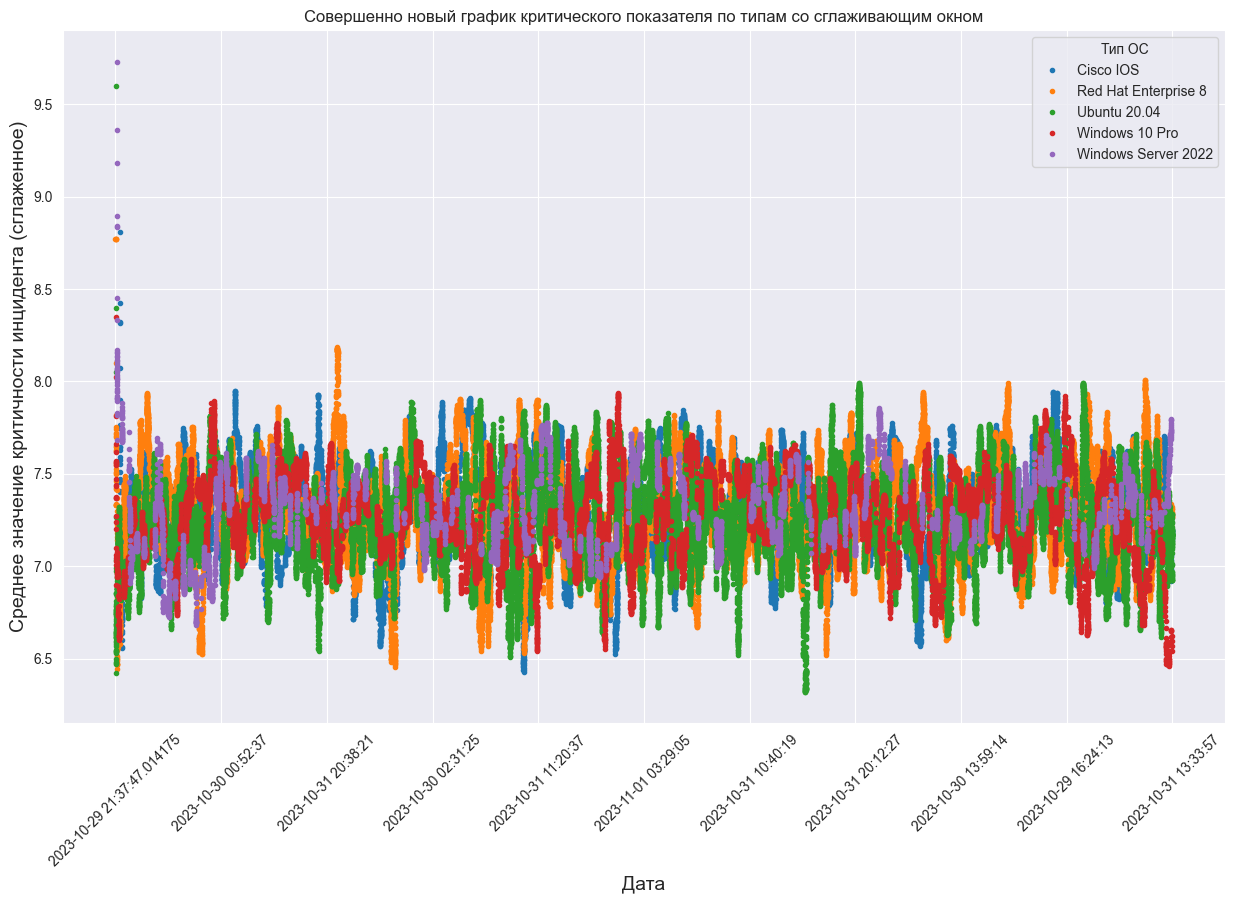

In [3]:
def get_os(row):
    cvss = []
    for i in range(len(assets_df['id'])):
        if assets_df['id'][i].item() == row[0]:
            return (assets_df['os'][i])

        # cvss.append(assets_df['id'][i])
    # return cvss


# incidents_df['os'] = [ row for row in df_exploded]

# os = []
# merged_df_2 = incidents_df.head(100)
# for row in range(100):
#     os.append(get_os(merged_df_2['assets_id'][row]))

# merged_df_2['os'] = os
df_exploded = incidents_df.explode('vulnerabilities_id')
merged_df = df_exploded.merge(vulnerabilities_df, left_on='vulnerabilities_id', right_on='id', how='inner')

df_exploded_2 = merged_df.explode('assets_id')
merged_df_2 = df_exploded_2.merge(assets_df, left_on='assets_id', right_on='id', how='inner')

# print(get_os(incidents_df['assets_id'][100]))

merged_df_2['os by crit_rate'] = merged_df_2\
.groupby('os')['crit_rate']\
.transform(lambda x: x.rolling(window=150, min_periods=1).mean())

incs_gby_type = merged_df_2.groupby('os')

f = plt.figure(figsize=(15, 9))
ax = f.add_subplot(111, label='1')


incs_for_plot1 = incs_gby_type['os by crit_rate']  # [['start_time', 'events_count_smooth']]

incs_for_plot1.plot(ls='', marker='.')

fontsize=14
ax.set_xticks(labels=merged_df_2['start_time'][::merged_df_2.shape[0]//10], ticks=list(range(0, merged_df_2.shape[0], merged_df_2.shape[0]//10)), rotation=45)
ax.set_title('Совершенно новый график критического показателя по типам со сглаживающим окном')
ax.set_ylabel('Среднее значение критичности инцидента (сглаженное)', fontsize=fontsize)
ax.set_xlabel('Дата', fontsize=fontsize)
ax.legend(title='Тип ОС')
plt.grid(True)

# plt.tight_layout()
plt.show()




Вывод: атаки на убунту и циско ОС самые критичные!!!!!!!

# Задача 3

Цель виртуализации: Определить наиболее часто подвергаем тип оборудования под различные типы уязвимостей

Задача виртуализации: Строим хит мап, берем инфу о типах оборудования и типах уязвимостей и анализируем эту информацию на глаз.

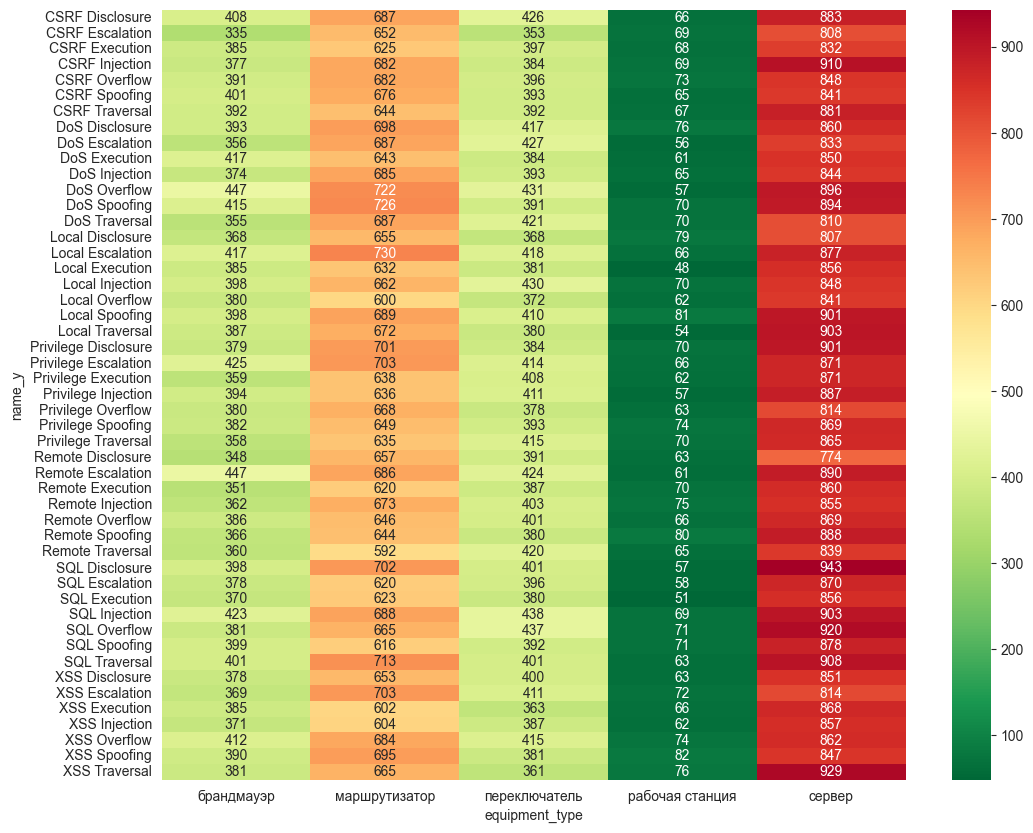

In [4]:
df_exploded = incidents_df.explode('vulnerabilities_id')
merged_df = df_exploded.merge(vulnerabilities_df, left_on='vulnerabilities_id', right_on='id', how='inner')

df_exploded_2 = merged_df.explode('assets_id')
merged_df_2 = df_exploded_2.merge(assets_df, left_on='assets_id', right_on='id', how='inner')

plt.figure(figsize=(12, 10))
heatmap_data = merged_df_2.groupby(['equipment_type', 'name_y']).size().reset_index(name='count')
pivot_data = heatmap_data.pivot_table(index='name_y', columns='equipment_type', values='count')
sns.heatmap(pivot_data, annot=True, fmt="g", cmap='RdYlGn_r')
plt.show()

 Вывод: Сервера несчадно атакуют, а на рабочую станцию всем плевать, типы уязвимостей при этом используются довольно равномерно